In [1]:
import load_files as lf
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
import measurement_analysis as ma
import pickle
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
file_path = "/Users/blazejmanczak/Desktop/Q1/DataChallenge3/"
flow_data_DRU, level_data_DRU = lf.get_measurements(file_path + "waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/RG8150")
rain_data = lf.get_rain(file_path +"/waterschap-aa-en-maas_sewage_2019/sewer_data/rain_timeseries")
data = lf.sdf(file_path + "waterschap-aa-en-maas_sewage_2019/sewer_model/aa-en-maas_sewer_shp")

In [3]:
# Either run this cell or open pickle in the next one
df = ma.measurement_analysis(flow_data_DRU, level_data_DRU, rain_data, area_data=data.area_data,
                             village_code="DRU", dry_threshold = 2.5)

In [10]:
"""
#Save pickle
filename = 'ma_df'
outfile = open(filename,'wb')
pickle.dump(df,outfile)
outfile.close()
"""


## Some exploration 

In [17]:
df.flow_data.set_index('TimeStamp', inplace= True, drop = False)
df.level_data.set_index('TimeStamp', inplace= True, drop = False)

In [29]:
# Only take dry days (something is wrong here)
df.level_data = df.level_data[df.level_data['Dry'] == 1]
df.flow_data = df.flow_data[df.flow_data['Dry'] == 1]

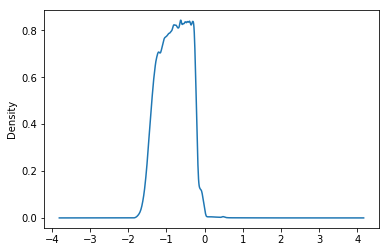

In [19]:
# Check for the  min and max "off" level - the level when the pump is not working
df.level_data['Value'].plot.kde()

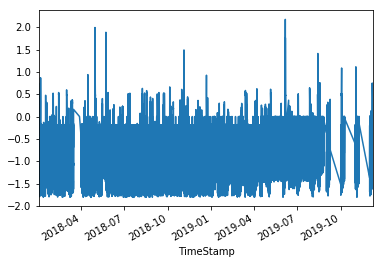

In [20]:
df.level_data['Value'].plot()

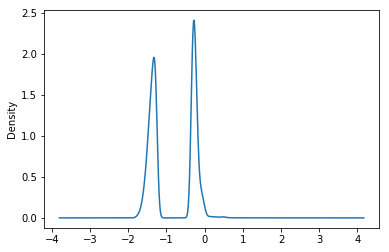

In [134]:
df.level_data[(df.level_data['Value'] < -1.25) | (df.level_data['Value'] > -0.35) ]['Value'].plot.kde()

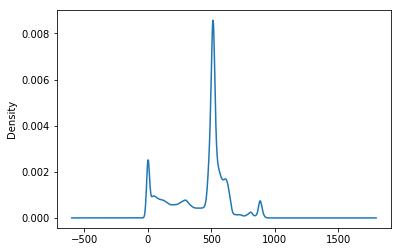

In [37]:
df.flow_data['Value'].plot.kde()

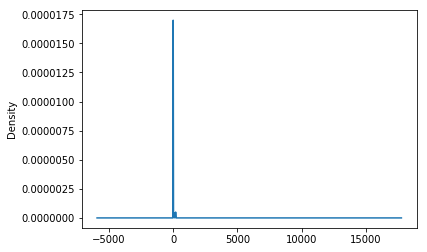

In [60]:
df.flow_data['Flow'].plot.kde()

In [38]:
df.flow_data['Value'].describe()

count    2.767759e+06
mean     4.211912e+02
std      2.187778e+02
min      0.000000e+00
25%      2.631596e+02
50%      5.072115e+02
75%      5.403768e+02
max      1.200000e+03
Name: Value, dtype: float64

## Assumptions coming in strong
Take the data only when max/min level is reached and when the flow is 0 or max
Assume max flow to be 500m^3/h +- 20 and pump not working to be 0 - 30

In [121]:
level_data = df.level_data[(df.level_data['Value'] < -1.25) | #1.25 becasue then we get approx the same distribution for on and off
                           ((df.level_data['Value'] > -0.35) &(df.level_data['Value'] < 0 ) ) ]
    
flow_data = df.flow_data[(df.flow_data['Value'] < 30) |
                        ((df.flow_data['Value'] > 480) & (df.flow_data['Value'] < 520)) ]   

In [122]:
level_data["Minute"] = level_data["TimeStamp"].apply(lambda i: i.minute)
flow_data['Minute'] = flow_data['TimeStamp'].apply(lambda i: i.minute)

level_data["Second"] = level_data["TimeStamp"].apply(lambda i: i.second)
flow_data['Second'] = flow_data['TimeStamp'].apply(lambda i: i.second)

In [150]:
merged = pd.merge(level_data[['Value','Date', 'Hour', 'Minute', 'Second', 'TimeStamp']], 
        flow_data[['Value','Date', 'Hour', 'Minute', 'Second']],
                  on = ['Date', 'Hour', 'Minute', 'Second'], how = 'inner' )

In [151]:
merged[merged['Value_x'] < -1.25] # only 10k rows!

,Value_x,Date,Hour,Minute,Second,TimeStamp,Value_y
23,-1.308371,2018-01-02,5,2,40,2018-01-02 05:02:40,26.264680
24,-1.252133,2018-01-02,5,2,55,2018-01-02 05:02:55,0.763903
25,-1.280499,2018-01-02,5,49,0,2018-01-02 05:49:00,19.949660
26,-1.377627,2018-01-02,6,10,55,2018-01-02 06:10:55,0.695120
27,-1.346156,2018-01-02,6,58,10,2018-01-02 06:58:10,6.053833
...,...,...,...,...,...,...,...
24453,-1.399066,2019-12-06,2,19,46,2019-12-06 02:19:46,21.539890
24454,-1.344673,2019-12-06,2,20,1,2019-12-06 02:20:01,0.694426
24459,-1.572088,2019-12-06,5,0,7,2019-12-06 05:00:07,8.873676
24527,-1.251913,2019-12-07,16,5,20,2019-12-07 16:05:20,483.694300


### We are looking for a pattern: 
low level that is growing over time (pump is off) - a at some point (the level approaches on level) pump starts working and the level drop significantly. How do we quantity it? 

In [159]:
one_day = merged[merged['Date'] == merged['Date'][266]]
one_day.head(15)

,Value_x,Date,Hour,Minute,Second,TimeStamp,Value_y
220,-0.303770,2018-01-10,2,43,25,2018-01-10 02:43:25,488.183000
221,-0.297026,2018-01-10,4,42,55,2018-01-10 04:42:55,491.045600
222,-0.270788,2018-01-10,7,12,40,2018-01-10 07:12:40,490.796700
223,-1.277020,2018-01-10,7,18,55,2018-01-10 07:18:55,5.289626
224,-0.191673,2018-01-10,7,33,10,2018-01-10 07:33:10,10.347210
225,-0.268824,2018-01-10,7,34,25,2018-01-10 07:34:25,502.561400
226,-1.293380,2018-01-10,7,40,45,2018-01-10 07:40:45,0.694433
227,-0.274085,2018-01-10,8,1,45,2018-01-10 08:01:45,504.826800
228,-1.305239,2018-01-10,8,8,10,2018-01-10 08:08:10,12.391290
229,-1.283782,2018-01-10,8,8,15,2018-01-10 08:08:15,2.087483


In [158]:
level_data['1-10-2018'][level_data['Hour'] == 7]

,RG_ID,TimeStamp,Value,DataQuality,Date,Hour,Month,Weekend,TimeSpan,Freq,Delta,max,min,Dry,Minute,Second
TimeStamp,,,,,,,,,,,,,,,,
2018-01-10 07:07:10,8150,2018-01-10 07:07:10,-0.340073,1,2018-01-10,7,1,0,55.0,0.018182,0.031336,0,0,1,7,10
2018-01-10 07:07:45,8150,2018-01-10 07:07:45,-0.320282,1,2018-01-10,7,1,0,35.0,0.028571,0.019791,0,0,1,7,45
2018-01-10 07:08:40,8150,2018-01-10 07:08:40,-0.287462,1,2018-01-10,7,1,0,55.0,0.018182,0.032820,0,0,1,8,40
2018-01-10 07:09:15,8150,2018-01-10 07:09:15,-0.266187,1,2018-01-10,7,1,0,35.0,0.028571,0.021275,0,0,1,9,15
2018-01-10 07:10:10,8150,2018-01-10 07:10:10,-0.236170,1,2018-01-10,7,1,0,55.0,0.018182,0.030017,0,0,1,10,10
2018-01-10 07:10:45,8150,2018-01-10 07:10:45,-0.214730,1,2018-01-10,7,1,0,35.0,0.028571,0.021441,1,0,1,10,45
2018-01-10 07:12:40,8150,2018-01-10 07:12:40,-0.270788,1,2018-01-10,7,1,0,115.0,0.008696,-0.056058,0,0,1,12,40
2018-01-10 07:12:45,8150,2018-01-10 07:12:45,-0.287099,1,2018-01-10,7,1,0,5.0,0.200000,-0.016311,0,0,1,12,45
2018-01-10 07:13:00,8150,2018-01-10 07:13:00,-0.323399,1,2018-01-10,7,1,0,15.0,0.066667,-0.036300,0,0,1,13,0


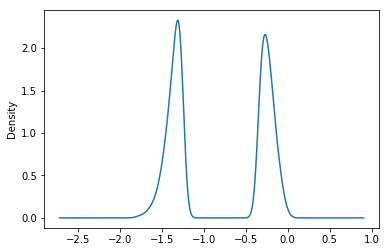

In [132]:
merged['Value_x'].plot.kde()

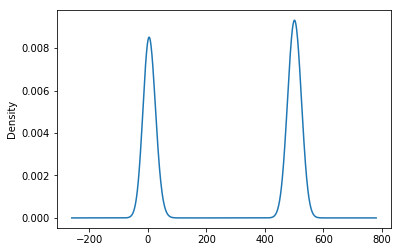

In [133]:
merged['Value_y'].plot.kde()